In [1]:
import glob
import numpy as np

In [2]:
frds = glob.glob('output/ccx/*/*.frd')
dats = glob.glob('output/ccx/*/*.dat')

In [3]:
# dats = dats[1:]
# frds = frds[1:]

In [4]:
from djccx.read_dat import read_dat
from djccx.frd.readfrd import readfrd

In [5]:
t_l = 0.475 #  Espesor de la capa [mm]
t_n = 2.934
A_s = 0.283 # mm^2

r = 3*t_l/8 
d = (A_s - np.pi*r**2)/(2*r) # Area de la capa [mm^2]
params_composite ={
    "r"         :  r,
    "d"         :  d,
    "h"         :  t_l,
    "z0"        :  0,
    "density"   : 5,
}
params_ccx = {
    "epsilon" : 0.1,
    "x_fixed" : True
}
params = {
    "mesh" : params_composite,
    "ccx"  : params_ccx,
}

In [6]:
from FEM_traccion.CreateLines.CreateLines import CreateLines

lines = CreateLines({
        "r": 2.5,
        "Nx_sq": 1,
        "Ny_sq": 1,
        "type":  'sin' # 'circle' or 'sin'
    })

In [7]:
frds

['output/ccx\\SX\\main.frd',
 'output/ccx\\SY\\main.frd',
 'output/ccx\\X\\main.frd',
 'output/ccx\\Y\\main.frd']

In [8]:
design = [ lines["designs"][idesign]["ly_0"]
         for idesign in ["SX","SY","X","Y"] ]

In [9]:
from gmshtools.grid_section import grid_section
from matplotlib import pyplot as plt

In [10]:
%matplotlib ipympl

In [11]:
frds

['output/ccx\\SX\\main.frd',
 'output/ccx\\SY\\main.frd',
 'output/ccx\\X\\main.frd',
 'output/ccx\\Y\\main.frd']

In [12]:
ifrd = readfrd(frds[0])
idesign = design[0]


In [13]:
data = ifrd["data"]

In [14]:
ymin = 0.5 
ymax = 9.5
xmin = 0.5
xmax = 9.5

data = data[data["x"] > xmin]
data = data[data["x"] < xmax]
data = data[data["y"] > ymin]
data = data[data["y"] < ymax]


In [15]:
ifrd = readfrd(frds[0])


In [16]:
from scipy.interpolate import NearestNDInterpolator


def compute_P1_max(data,idesign,params_composite):

    x = data["x"]
    y = data["y"]
    z = data["z"]
    P1 = data["P1"]

    fcn = NearestNDInterpolator((x,y,z),P1)

    d = params_composite["d"]
    r = params_composite["r"]

    P1_mu_list = []
    for jj,jtrajs in enumerate(idesign):

        jtraj_diff = np.diff(jtrajs,axis=0)

        for j in range(0,len(jtraj_diff),600):

            vec_z =  jtraj_diff[j]
            vec_z = vec_z/np.linalg.norm(vec_z)
            vec_x = np.cross(vec_z, [0,0,1])
            vec_x = vec_x/np.linalg.norm(vec_x)

            X,Y,Z = grid_section(jtrajs[j][0],
                                jtrajs[j][1],
                                jtrajs[j][2],
                                vec_z,
                                vec_x,
                                0.8*d,
                                0.8*r,
                                rho=150)
            Z = Z + params_composite["h"]/2
            P1 = fcn(X,Y,Z)
            P1_mu = np.mean(P1)
            P1_mu_list.append(P1_mu)

        # ============================

    P1_max = np.max(P1_mu_list)

    return P1_max

In [17]:
from djccx.inp.inp import inp

In [18]:
frds
inp_paths = [ i.replace(".frd",".inp") for i in frds]

In [19]:
inp_paths

['output/ccx\\SX\\main.inp',
 'output/ccx\\SY\\main.inp',
 'output/ccx\\X\\main.inp',
 'output/ccx\\Y\\main.inp']

In [20]:
t_l/4

0.11875

In [21]:
# neartest neighbor interpolation

P1_time_design = []
Sapl_list_design = []
P1_time_matrix_design = []
for ii in range(4):

    idesign = design[ii]
    ifrd = readfrd(frds[ii])
    inp_f = inp(inp_paths[ii])

    #
    BOX_PLUS = inp_f.select("BOX_PLUS","elset")
    df = BOX_PLUS.GetUniqueNodes(inp_f)
    indx_frd = df.index.values

    P1_time   = []
    Sapl_list = []
    P1_fibres_time = []
    print("design",idesign)
    print("number of data blocks",len(ifrd["data_blocks"]))
    for data in ifrd["data_blocks"]:

        # =============================
        # compute Sigma Aplicado
        # ============================
        
        ancho = params_composite["z0"]*0.5 +params_composite["h"]
        largo = 10 
        A = ancho*largo
        Sapl = np.sum(data["F2"]*(data["y"] > data["y"].mean()))/A
        Sapl_list.append(Sapl)

        # =============================
        # compute P1_max of fibres
        # ============================
        data_cp = data.copy()
        data_cp = data_cp[data_cp["x"] > xmin]
        data_cp = data_cp[data_cp["x"] < xmax]
        data_cp = data_cp[data_cp["y"] > ymin]
        data_cp = data_cp[data_cp["y"] < ymax]

        P1_max = compute_P1_max(data_cp,idesign,params_composite)
        
        P1_time.append(P1_max)

        # ============================
        # Compute P1_max of matrix
        # ============================
        data_cp = data.copy()

        nodes_matrix = data_cp.loc[indx_frd]

        data_cp = data_cp[data_cp["x"] > xmin]
        data_cp = data_cp[data_cp["x"] < xmax]
        data_cp = data_cp[data_cp["y"] > ymin]
        data_cp = data_cp[data_cp["y"] < ymax]
        
        id_max = np.argmax(data_cp["P1"])

        P1_max = data_cp["P1"].iloc[id_max]
        x_max = data_cp["x"].iloc[id_max]
        y_max = data_cp["y"].iloc[id_max]
        z_max = data_cp["z"].iloc[id_max]

        dist = np.sqrt((x_max - nodes_matrix["x"])**2 + \
                       (y_max - nodes_matrix["y"])**2 + \
                       (z_max - nodes_matrix["z"])**2)
        
        nodes_matrix = nodes_matrix[dist < 0.15]

        print("number of nodes in matrix",len(nodes_matrix))
        # mean P1  
        # P1_max = np.mean(nodes_matrix["P1"])

        P1_fibres_time.append(P1_max)
        # ============================

    P1_time_matrix_design.append(P1_fibres_time)
    P1_time_design.append(P1_time)
    Sapl_list_design.append(Sapl_list)

design [array([[0.00000000e+00, 2.50000000e+00, 0.00000000e+00],
       [5.00100020e-04, 2.49999988e+00, 0.00000000e+00],
       [1.00020004e-03, 2.49999951e+00, 0.00000000e+00],
       ...,
       [2.49899980e+00, 1.57111045e-03, 0.00000000e+00],
       [2.49949990e+00, 7.85555262e-04, 0.00000000e+00],
       [2.50000000e+00, 1.53080850e-16, 0.00000000e+00]], shape=(5000, 3)), array([[7.50000000e+00, 1.53080850e-16, 0.00000000e+00],
       [7.50050010e+00, 7.85555262e-04, 0.00000000e+00],
       [7.50100020e+00, 1.57111045e-03, 0.00000000e+00],
       ...,
       [9.99899980e+00, 2.49999951e+00, 0.00000000e+00],
       [9.99949990e+00, 2.49999988e+00, 0.00000000e+00],
       [1.00000000e+01, 2.50000000e+00, 0.00000000e+00]], shape=(5000, 3)), array([[ 2.5       , 10.        ,  0.        ],
       [ 2.5005001 ,  9.99921444,  0.        ],
       [ 2.5010002 ,  9.99842889,  0.        ],
       ...,
       [ 7.4989998 ,  9.99842889,  0.        ],
       [ 7.4994999 ,  9.99921444,  0.     

In [22]:
%matplotlib inline

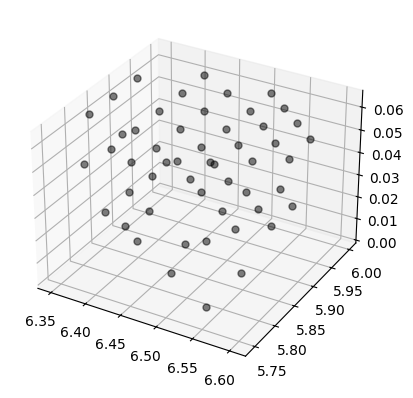

In [23]:
# plot scatter nodes_matrix 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.plot(nodes_matrix["x"],
         nodes_matrix["y"],
         nodes_matrix["z"],marker='o', alpha=0.5, color='k', 
         markersize=5,linestyle='None')

plt.show()


In [24]:
Sapl_list_design[0]

[np.float64(0.0), np.float64(417.1723447409688), np.float64(834.3446684150243)]

In [25]:
P1_time_matrix_design[0]

[np.float64(0.0),
 np.float64(1322.3866843091887),
 np.float64(2644.773368616269)]

In [26]:
P1_time_design[0]

[np.float64(0.0),
 np.float64(1214.6377657468013),
 np.float64(2429.276367065699)]

In [27]:
%matplotlib inline

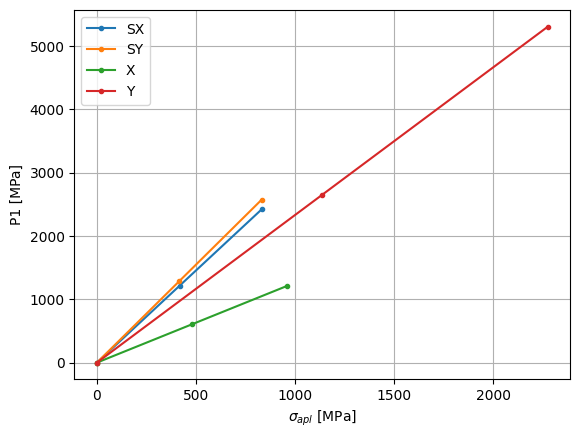

In [28]:
fig = plt.figure()
labels = ["SX","SY","X","Y"]
for ii in range(4):
    plt.plot(Sapl_list_design[ii],P1_time_design[ii],'.-', label=labels[ii])
plt.xlabel(r"$\sigma_{apl}$ [MPa]")
plt.ylabel("P1 [MPa]")
plt.legend()
plt.grid()  

In [29]:
P1_time_design

[[np.float64(0.0),
  np.float64(1214.6377657468013),
  np.float64(2429.276367065699)],
 [np.float64(0.0),
  np.float64(1286.4095964124097),
  np.float64(2572.819400329826)],
 [np.float64(0.0),
  np.float64(604.1855682870562),
  np.float64(1208.3707882646208)],
 [np.float64(0.0),
  np.float64(2652.2214815203724),
  np.float64(5304.440891245871)]]

In [30]:
ratio_fibra = [ P1_time_design[ii][-1]/Sapl_list_design[ii][-1] for ii in range(4)]
ratio_matrix = [ P1_time_matrix_design[ii][-1]/Sapl_list_design[ii][-1] for ii in range(4)]
ratio = {
    "SX": {"fibra": ratio_fibra[0], "matrix": ratio_matrix[0]},
    "SY": {"fibra": ratio_fibra[1], "matrix": ratio_matrix[1]},
    "X": {"fibra": ratio_fibra[2], "matrix": ratio_matrix[2]},
    "Y": {"fibra": ratio_fibra[3], "matrix": ratio_matrix[3]}
}

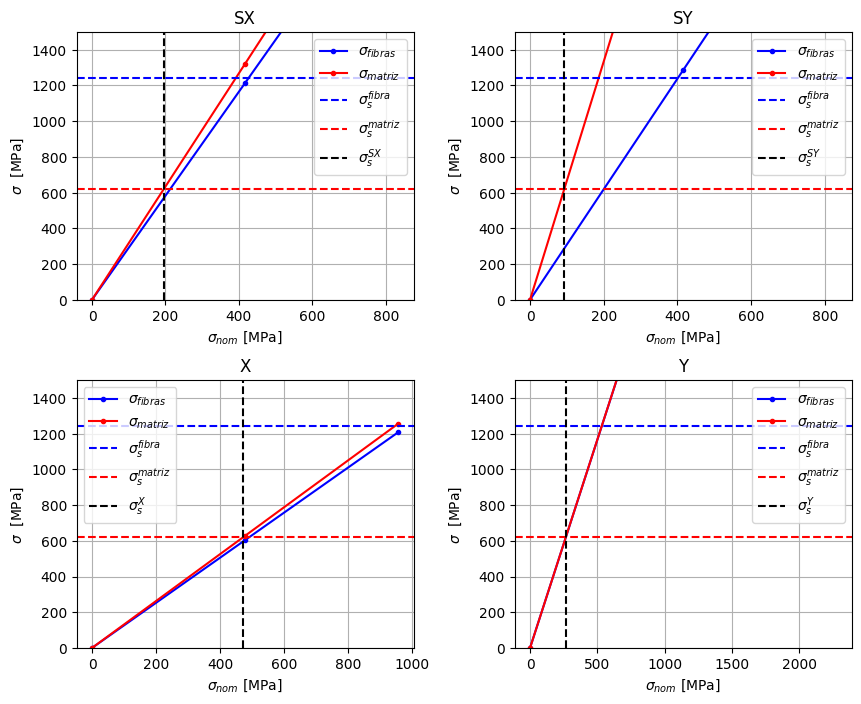

In [40]:
labels = ["SX","SY","X","Y"]
fig = plt.figure(figsize=(10, 8))
#subplot 
plt.subplots_adjust(wspace=0.3, 
                    hspace=0.3)

Sfibre = 1243.05186
Smatrix = 620.94557



colors = ["b","r"]

Srotura = {}
for ii in range(4):

    # subplot 
    plt.subplot(2,2,ii+1)
    plt.plot(Sapl_list_design[ii],P1_time_design[ii],'.-', label=r"$\sigma_{fibras}$",color='b')
    plt.plot(Sapl_list_design[ii],P1_time_matrix_design[ii],'.-', label= r"$\sigma_{matriz}$",color='r')
    
    plt.axhline(y=Sfibre, linestyle='--', label=r"$\sigma_s^{fibra}$",color='b')
    plt.axhline(y=Smatrix, linestyle='--', label=r"$\sigma_s^{matriz}$",color='r')

    Sposibles  = [Sfibre/ratio[labels[ii]]["fibra"],Smatrix/ratio[labels[ii]]["matrix"]]
    idx_S = np.argmin(Sposibles)
    S = Sposibles[idx_S]

    Srotura[labels[ii]] = S

    label = r"$\sigma_s^{CC}$"  
    label = label.replace("CC",labels[ii])
    plt.axvline(x=S, linestyle='--', 
                label=label,
                color="k")

    # [0,0] -> [ S,]
    plt.xlabel(r"$\sigma_{nom}$ [MPa]")
    plt.ylabel(r"$\sigma$  [MPa]")
    plt.title(labels[ii])
    plt.legend()
    plt.grid()  
    plt.ylim(0,1500)
    # plt.xlim(0,1000)


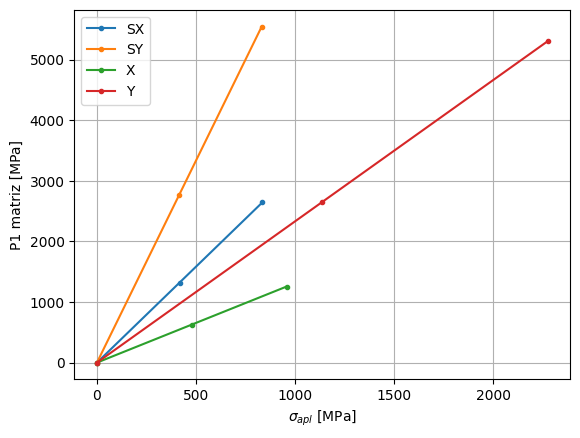

In [32]:
fig = plt.figure()
labels = ["SX","SY","X","Y"]
for ii in range(4):
    plt.plot(Sapl_list_design[ii],P1_time_matrix_design[ii],'.-', label=labels[ii])
plt.xlabel(r"$\sigma_{apl}$ [MPa]")
plt.ylabel("P1 matriz [MPa]")
plt.legend()
plt.grid()  

In [33]:
Srotura

{'SX': np.float64(335.372866421896),
 'SY': np.float64(159.2708441203259),
 'X': np.float64(809.8873480149986),
 'Y': np.float64(455.54406528393577)}

In [34]:

ratio

{'SX': {'fibra': np.float64(2.9115981188931324),
  'matrix': np.float64(3.169881068024865)},
 'SY': {'fibra': np.float64(3.0956626241686074),
  'matrix': np.float64(6.674743929886223)},
 'X': {'fibra': np.float64(1.262402286953406),
  'matrix': np.float64(1.312641940395286)},
 'Y': {'fibra': np.float64(2.331728711866128),
  'matrix': np.float64(2.3336756661232894)}}

In [35]:
import pandas as pd 
pd.DataFrame(ratio)

,SX,SY,X,Y
fibra,2.911598,3.095663,1.262402,2.331729
matrix,3.169881,6.674744,1.312642,2.333676


In [36]:
ratio

{'SX': {'fibra': np.float64(2.9115981188931324),
  'matrix': np.float64(3.169881068024865)},
 'SY': {'fibra': np.float64(3.0956626241686074),
  'matrix': np.float64(6.674743929886223)},
 'X': {'fibra': np.float64(1.262402286953406),
  'matrix': np.float64(1.312641940395286)},
 'Y': {'fibra': np.float64(2.331728711866128),
  'matrix': np.float64(2.3336756661232894)}}

In [37]:
P1_time_design

[[np.float64(0.0),
  np.float64(1214.6377657468013),
  np.float64(2429.276367065699)],
 [np.float64(0.0),
  np.float64(1286.4095964124097),
  np.float64(2572.819400329826)],
 [np.float64(0.0),
  np.float64(604.1855682870562),
  np.float64(1208.3707882646208)],
 [np.float64(0.0),
  np.float64(2652.2214815203724),
  np.float64(5304.440891245871)]]

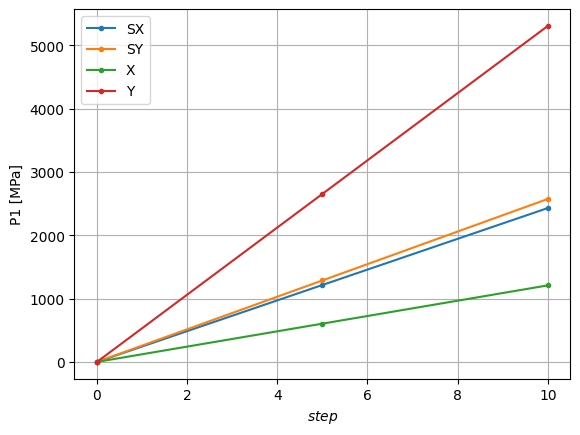

In [38]:
fig = plt.figure()
labels = ["SX","SY","X","Y"]
epsilon = np.linspace(0,1,3)/0.1
for ii in range(4):
    plt.plot(epsilon,P1_time_design[ii],'.-', label=labels[ii])
plt.xlabel(r"$step$")
plt.ylabel("P1 [MPa]")
plt.legend()
plt.grid()  

In [39]:
t_l = 0.475 #  Espesor de la capa [mm]
t_n = 2.934

r = 3*t_l/8 
d = (A_s - np.pi*r**2)/(2*r) # Area de la capa [mm^2]
params_composite ={
    "r"         :  r,
    "d"         :  d,
    "h"         :  t_l,
    "z0"        :  0,
    "density"   : 5,
}

E_resina = 637.4322499999998
E_carbon = 15333.333333333334
E_nucleo = 800